In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
data = pd.read_csv("daily-min-temperatures.csv")
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
lag = 3 #  we are making a AR(3) model, thus the lag is kept as 3

for i in range(1, lag + 1):
    data[f"lag_{i}"] = data["Temp"].shift(i)

data = data.dropna().reset_index(drop=True) # removed all NaN rows
data.head()


,Date,Temp,lag_1,lag_2,lag_3
0,1981-01-04,14.6,18.8,17.9,20.7
1,1981-01-05,15.8,14.6,18.8,17.9
2,1981-01-06,15.8,15.8,14.6,18.8
3,1981-01-07,15.8,15.8,15.8,14.6
4,1981-01-08,17.4,15.8,15.8,15.8


In [5]:
split_ratio = 0.8

train_size = int(len(data)*split_ratio)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

X_train = torch.tensor(train[[f"lag_{i}" for i in range(1,lag+1)]].values, dtype = torch.float32)
y_train = torch.tensor(train["Temp"].values, dtype = torch.float32).view(-1,1)

X_test = torch.tensor(test[[f"lag_{i}" for i in range(1,lag+1)]].values, dtype = torch.float32)
y_test = torch.tensor(test["Temp"].values, dtype = torch.float32).view(-1,1)

pd.DataFrame(X_train).head()



,0,1,2
0,18.799999,17.900000,20.700001
1,14.600000,18.799999,17.900000
2,15.800000,14.600000,18.799999
3,15.800000,15.800000,14.600000
4,15.800000,15.800000,15.800000


In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)


In [7]:
model = LinearRegressionModel(lag)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [8]:
num_epochs = 200
losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [20/200], Loss: 544.7761
Epoch [40/200], Loss: 286.7748
Epoch [60/200], Loss: 135.6071
Epoch [80/200], Loss: 58.9856
Epoch [100/200], Loss: 25.6348
Epoch [120/200], Loss: 13.3399
Epoch [140/200], Loss: 9.5572
Epoch [160/200], Loss: 8.5962
Epoch [180/200], Loss: 8.3886
Epoch [200/200], Loss: 8.3379


In [9]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)


In [10]:
rmse = torch.sqrt(criterion(y_pred_test, y_test))
print(f"\nRMSE: {rmse.item():.3f}")



RMSE: 2.634


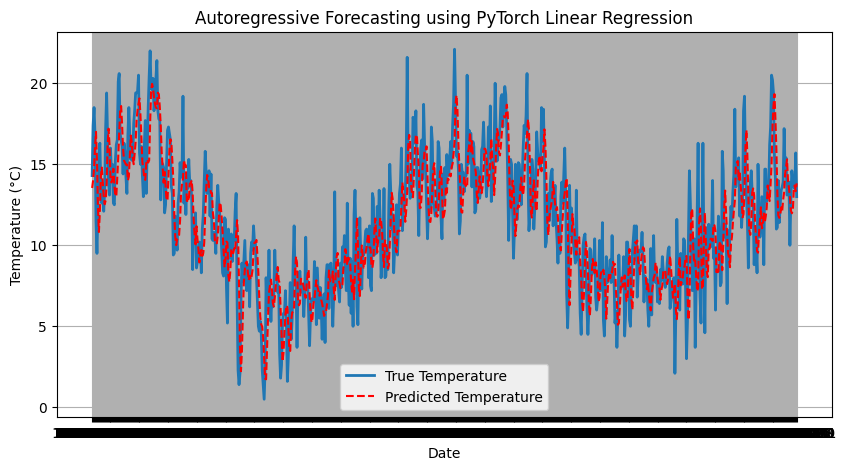

In [11]:
plt.figure(figsize=(10,5))
plt.plot(test['Date'], y_test.numpy(), label='True Temperature', linewidth=2)
plt.plot(test['Date'], y_pred_test.numpy(), label='Predicted Temperature', linestyle='dashed', color='red')
plt.title("Autoregressive Forecasting using PyTorch Linear Regression")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()
